In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#sample y ~ unif[-3,3]
#e.g. 1: sample Z ~ gamma(1,0.3)
#set X = tanh(Y)+Z
#save (X,Y)

#plot examples for y = {-1.2,0,1.2}

In [2]:
def get_conditional_sample(y):
    z = np.random.gamma(1,0.3)
    x = np.tanh(y) + z
    return (x,y,z)

In [3]:
def get_sample():
    y = np.random.uniform(-3,3)
    z = np.random.gamma(1,0.3)
    x = np.tanh(y) + z
    return (x,y)

In [41]:
samples=[]

for i in range(10000):
    sample = get_sample()
    samples.append(sample)
    

In [52]:
#forward process
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes a datapoint and a time as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance

    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 2
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [53]:
#simple NN
import torch.nn as nn

class FeedForwardNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, t):
        x = torch.cat((x, t))
        #x = x.type(torch.DoubleTensor)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


In [54]:
input_size = 3  # Size of the input (2D point and time step)
hidden_size = 100
output_size = 2  # Size of the output (2D point)

model = FeedForwardNetwork(input_size, hidden_size, output_size)

In [10]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [ ]:
#nn needs to predict the noise given the point and the timestep
#so, feed in 3D point (x, y, t) and predict (x_noise, y_noise)
#need a training dataset, lets say 10000 points, each with a random t value from 0-499, and the noise produced



In [11]:
samples_with_t = [(x,y,np.random.randint(low=1,high=500)) for (x,y) in samples]
tensor_samples = [torch.tensor(i) for i in samples_with_t]

In [12]:
forward_diffusion_sample(tensor_samples[0][:2], torch.Tensor([tensor_samples[0][2]]).type(torch.int64))

(tensor([-0.7202, -0.6367], dtype=torch.float64),
 tensor([-0.5714, -0.2292], dtype=torch.float64))

In [83]:
noised_samples = [forward_diffusion_sample(i[:2], torch.Tensor([i[2]]).type(torch.int64)) for i in tensor_samples]

In [42]:
tensor_samples = [torch.tensor(i) for i in samples]

In [55]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

BATCH_SIZE = 1

dataloader = DataLoader(tensor_samples, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [56]:
from torch.optim import Adam


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 20 # Try more!
model = model.float()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

        loss = get_loss(model, batch[0].float(), t)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")

Epoch 0 | step 9999 Loss: 0.8839086294174194 
Epoch 1 | step 9999 Loss: 0.5059821605682373 
Epoch 2 | step 9999 Loss: 0.2597588896751404 
Epoch 3 | step 9999 Loss: 0.427243709564209 
Epoch 4 | step 9999 Loss: 0.8892417550086975 
Epoch 5 | step 9999 Loss: 0.9050236344337463 
Epoch 6 | step 9999 Loss: 1.2114890813827515 
Epoch 7 | step 9999 Loss: 0.9924232363700867 
Epoch 8 | step 9999 Loss: 0.8657582402229309 
Epoch 9 | step 9999 Loss: 0.10199076682329178 
Epoch 10 | step 9999 Loss: 0.6384630799293518 
Epoch 11 | step 9999 Loss: 0.3120958209037781 
Epoch 12 | step 9999 Loss: 0.809356689453125 
Epoch 13 | step 9999 Loss: 0.448310911655426 
Epoch 14 | step 9999 Loss: 0.9288243055343628 
Epoch 15 | step 9999 Loss: 0.3298145532608032 
Epoch 16 | step 9999 Loss: 1.223184585571289 
Epoch 17 | step 9999 Loss: 1.711341142654419 
Epoch 18 | step 9999 Loss: 0.4682563245296478 
Epoch 19 | step 9999 Loss: 0.3548482060432434 


In [57]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

In [58]:
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = 2
    img = torch.randn((img_size), device=device)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        #img = torch.clamp(img, -3.0, 3.0)
    return img
  

In [59]:
test_samples = [sample_plot_image() for i in range(1000)]

In [110]:
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0

    # Iterate over the training dataset
    for inputs, targets in training_dataset:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(training_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")



NameError: name 'training_dataset' is not defined

In [36]:
inputs = samples[:10]

In [37]:
inputs

[(1.1910897458729652, 2.9874318024848856),
 (1.3964392260601923, 2.0805303450713177),
 (-0.9766400572565901, -2.3835748294331376),
 (1.0241315105827398, 2.939626018404687),
 (1.0184709403840353, 2.715602620531005),
 (0.9988195003996654, 1.7160956999023025),
 (0.7430086852709902, 0.5465424487810191),
 (0.735900144392415, 0.3097831280767953),
 (1.2580126870477204, 2.4680649462598954),
 (-0.36201248122902707, -0.5098656462155753)]

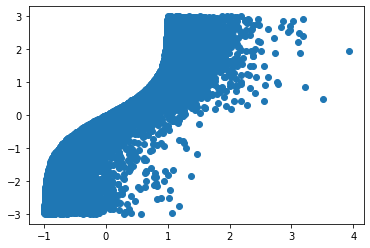

In [60]:
#true
plt.scatter([i[0] for i in samples], [i[1] for i in samples])

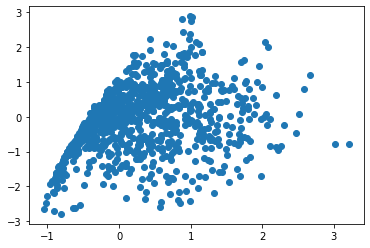

In [61]:
#new
plt.scatter([i[0] for i in test_samples], [i[1] for i in test_samples])

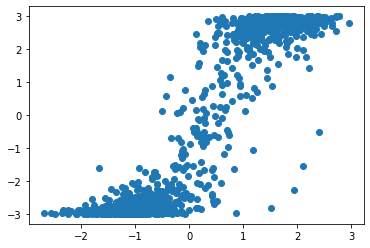

In [137]:
#old
plt.scatter([i[0] for i in test_samples], [i[1] for i in test_samples])

In [ ]:
#sample from X_N ~ 2D normal(0,I_2) dist
#sample from X_k~p_k|k+1=N(B_k+1(x_k+1,y),2g_k+1 I_2) where B_k+1(x_k+1,y) = x_k+1 + g_k+1{x_k+1 + 2s(k+1,X_k+1,y)}

In [35]:
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  20802


In [37]:
model

FeedForwardNetwork(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
#learning from https://colab.research.google.com/github/varun-ml/diffusion-models-tutorial/blob/master/toy-density-estimation/colab_vanilla_diffusion_model.ipynb#scrollTo=800b2749-b552-4e5d-89c5-34528781ffba

In [247]:
y= -6 * torch.rand(10000) + 3

In [248]:
z = np.random.gamma(1,0.3, size = 10000)

In [249]:
x = np.tanh(y) + z

In [250]:
data_transformed = torch.vstack([x, y])

In [251]:
# train model
## schedules copied from https://huggingface.co/blog/annotated-diffusion

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.25
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

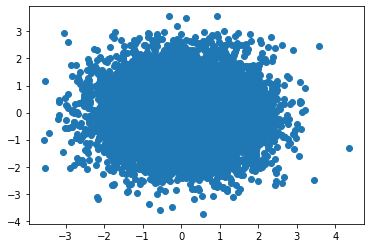

In [252]:
# Train model
timesteps = 300
# betas = linear_beta_schedule(timesteps)
betas = linear_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = torch.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = torch.sqrt(variance)

import torch.nn.functional as F

alphas_prev_ = F.pad(alphas_[:-1], [1, 0], "constant", 1.0)

# how to add noise of the data
def get_noisy(batch, timestep):
    added_noise_at_t = torch.normal(batch*torch.sqrt(alphas_[timestep]), std=sd[timestep])
    return added_noise_at_t
    
# def reverse_noisy(batch_pred, timestep):

added_noise_at_t = get_noisy(data_transformed, timesteps-1)
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])

posterior_variance = (1 - alphas) * (1 - alphas_prev_) / (1 - alphas)

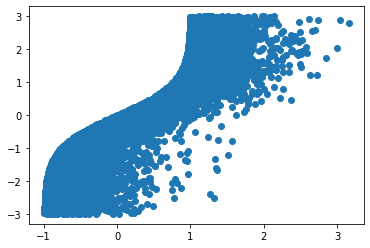

In [253]:
#target
plt.scatter(x, y)

In [254]:
torch.var_mean(data_transformed, dim=1), torch.var_mean(added_noise_at_t, dim=1)

((tensor([0.7532, 2.9753], dtype=torch.float64),
  tensor([0.3047, 0.0079], dtype=torch.float64)),
 (tensor([1.0039, 0.9988], dtype=torch.float64),
  tensor([-0.0001,  0.0035], dtype=torch.float64)))

In [255]:
torch.sqrt(torch.Tensor([1., 1.])*alphas_[49])

tensor([0.5935, 0.5935])

(tensor([0.0000e+00, 1.0002e-04, 1.0357e-03, 2.8055e-03, 5.4055e-03, 8.8300e-03,
         1.3071e-02, 1.8119e-02, 2.3962e-02, 3.0585e-02, 3.7974e-02, 4.6111e-02,
         5.4976e-02, 6.4549e-02, 7.4806e-02, 8.5724e-02, 9.7278e-02, 1.0944e-01,
         1.2218e-01, 1.3548e-01, 1.4929e-01, 1.6360e-01, 1.7836e-01, 1.9355e-01,
         2.0913e-01, 2.2508e-01, 2.4135e-01, 2.5791e-01, 2.7473e-01, 2.9177e-01,
         3.0901e-01, 3.2640e-01, 3.4392e-01, 3.6154e-01, 3.7921e-01, 3.9691e-01,
         4.1461e-01, 4.3229e-01, 4.4990e-01, 4.6743e-01, 4.8484e-01, 5.0211e-01,
         5.1922e-01, 5.3615e-01, 5.5286e-01, 5.6935e-01, 5.8559e-01, 6.0157e-01,
         6.1726e-01, 6.3265e-01, 6.4773e-01, 6.6249e-01, 6.7691e-01, 6.9098e-01,
         7.0470e-01, 7.1806e-01, 7.3105e-01, 7.4366e-01, 7.5590e-01, 7.6776e-01,
         7.7923e-01, 7.9033e-01, 8.0104e-01, 8.1137e-01, 8.2132e-01, 8.3089e-01,
         8.4010e-01, 8.4893e-01, 8.5741e-01, 8.6553e-01, 8.7329e-01, 8.8072e-01,
         8.8781e-01, 8.9457e

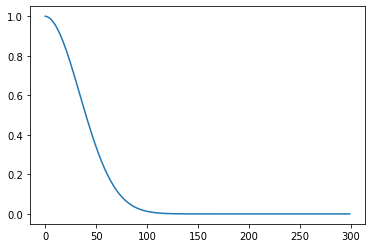

In [256]:
plt.plot(alphas_)

posterior_variance, alphas, alphas_, (alphas_prev_[1] / (1-alphas_prev_[1])) - (alphas_[1] / (1-alphas_[1]))

In [257]:
#model

In [258]:
learning_rate = 1e-3
batch_size = 100
epochs = 1

from torch import nn

class DenoisingModel(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32
        
        # data and timestep
        self.fc1 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.activation3 = nn.GELU()
        
        self.fc4 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.activation4 = nn.GELU()
        self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        self.activation5 = nn.GELU()
        self.fc6 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.activation6 = nn.GELU()
        
        self.fc7 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc7.weight)
        self.activation7 = nn.GELU()
        self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc8.weight)
        self.activation8 = nn.GELU()
        self.fc9 = nn.Linear(int(hidden_units), 2, bias=True)
        nn.init.xavier_uniform_(self.fc9.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = self.fc9(x)
        
        return x
      
denoising_model = DenoisingModel()
denoising_model = denoising_model.to(torch.double)
print(denoising_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=32, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=32, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=32, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)


loss: 0.674904  [   10/  100]
tensor([[ 0.2468, -0.4365],
        [ 0.2472, -0.4365],
        [ 0.2449, -0.4367],
        [ 0.2451, -0.4366],
        [ 0.2448, -0.4368],
        [ 0.2464, -0.4364],
        [ 0.2456, -0.4364],
        [ 0.2436, -0.4376],
        [ 0.2472, -0.4366],
        [ 0.2440, -0.4374]], dtype=torch.float64) tensor([[-0.6709, -1.6316],
        [ 0.9501,  1.6169],
        [ 1.1391,  0.8414],
        [ 1.0106,  1.5622],
        [-0.2195, -0.6516],
        [ 0.4298,  0.4180],
        [ 1.2820,  2.9462],
        [-0.6405, -0.9592],
        [ 1.0502,  2.6031]], dtype=torch.float64)


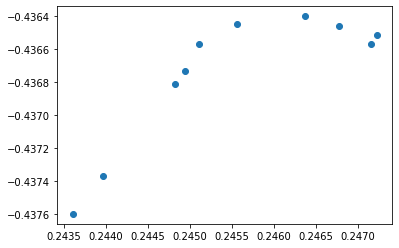

In [259]:
##### testing neural network above

test_noise_step = 5
data_noisy = get_noisy(data_transformed[:, 0:10], test_noise_step)
# torch.hstack([data_noisy, torch.Tensor(5)])
t_ = torch.Tensor([test_noise_step])
t_ = t_.repeat(10)
data_noisy = torch.vstack([data_noisy, t_])

with torch.no_grad():
    for epoch in range(1, epochs+1):
        data_pred = denoising_model(data_noisy.t())
        loss_ = loss_func(data_transformed[:, 0:10].t(), data_pred)
        # loss_.backward()
        # optimizer.step()
        loss, current = loss_.item(), 1 * 10
        print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    
print(data_pred, data_transformed[:, 1:10].t())

plt.scatter(data_pred.t()[0], data_pred.t()[1])

In [260]:
import os
import os.path as osp
from copy import deepcopy
import pickle
import sys

epochs = 300

def train_model(denoising_model, data_transformed, model_name):
    best_loss = sys.float_info.max
    ff = osp.join(os.getcwd(), 'saved_models', 'best', model_name + '_state.pkl')
    losses = []
    for epoch in range(1, epochs+1):
        for n in range(1, int(len(data_transformed[0])/batch_size) + 1):
        # for n in range(1, 1000):
            data_in_batch = data_transformed[:, (n-1)*batch_size:(n*batch_size)]
            idx = torch.randint(0, timesteps-1, (batch_size, )).long()
            timestep = idx.add(1)
            data_noisy = get_noisy(data_in_batch, timestep)
            optimizer.zero_grad(set_to_none=True)
            data_noisy_stacked = torch.vstack([data_noisy, timestep])
            pred_data = denoising_model(data_noisy_stacked.t())
            imp_weight = torch.sqrt(1/2 * ((alphas_prev_[timestep] / (1 - alphas_prev_[timestep])) - (alphas_[timestep]/(1 - alphas_[timestep]))))
            # loss on prediction
            loss_ = loss_func(data_in_batch.mul(imp_weight), pred_data.t().mul(imp_weight))
            # norm = tensor.norm(pred_data.sub(data_noisy), dim=0)
            # loss = loss_*norm
            loss_.backward()
            optimizer.step()
        ## evaluating noise on a fixed timestep to calculate best model
        
        with torch.no_grad():
            one_timestep = torch.Tensor([1]).repeat(batch_size).long()
            data_noisy_temp = get_noisy(data_in_batch, one_timestep)
            data_noisy_stacked_temp = torch.vstack([data_noisy_temp, one_timestep])
            pred_data_temp = denoising_model(data_noisy_stacked_temp.t())
            # loss on prediction
            loss_temp = loss_func(data_in_batch.mul(1), pred_data_temp.t().mul(1))
            losses.append(loss_temp.item())
            
        if loss_temp.item() < best_loss:
            best_loss = loss_temp.item()
            print(f"saving epoch: {epoch} loss: {best_loss:>7f}")
                
        if epoch % 20 == 0:
            loss = loss_temp.item()
            print(f"epoch: {epoch} loss: {loss:>7f}")

    return data_noisy, pred_data, data_in_batch, timestep, losses

data_noisy, pred_data, data_in_batch, timestep, losses = train_model(denoising_model, data_transformed, 'denoising_model')

saving epoch: 1 loss: 0.428422
saving epoch: 2 loss: 0.125085
saving epoch: 3 loss: 0.078427
saving epoch: 4 loss: 0.074018
saving epoch: 5 loss: 0.070048
saving epoch: 6 loss: 0.038493
saving epoch: 7 loss: 0.034152
saving epoch: 17 loss: 0.030328
saving epoch: 19 loss: 0.029498
epoch: 20 loss: 0.030029
saving epoch: 26 loss: 0.029195
saving epoch: 32 loss: 0.028421
saving epoch: 34 loss: 0.023735
saving epoch: 36 loss: 0.023430
epoch: 40 loss: 0.032317
saving epoch: 45 loss: 0.019603
saving epoch: 50 loss: 0.015834
saving epoch: 51 loss: 0.015486
saving epoch: 57 loss: 0.013607
epoch: 60 loss: 0.015004
saving epoch: 63 loss: 0.011054
saving epoch: 69 loss: 0.009666
saving epoch: 73 loss: 0.009421
saving epoch: 74 loss: 0.008984
saving epoch: 79 loss: 0.006769
epoch: 80 loss: 0.007846
saving epoch: 93 loss: 0.004357
saving epoch: 97 loss: 0.004169
saving epoch: 98 loss: 0.002204
epoch: 100 loss: 0.002564
epoch: 120 loss: 0.004084
saving epoch: 127 loss: 0.001391
epoch: 140 loss: 0.005

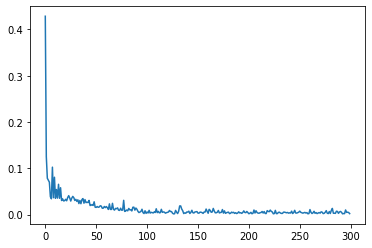

In [261]:
plt.plot(torch.Tensor(losses))

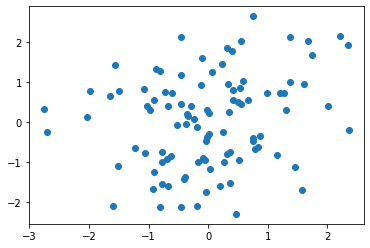

In [262]:
plt.scatter(data_noisy[0], data_noisy[1])

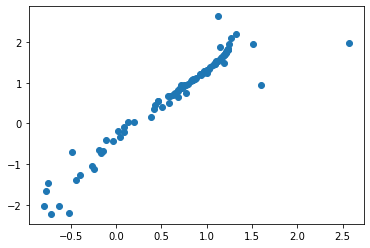

In [263]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

In [264]:
def generate_data(denoising_model):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 2048
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    data_noisy =  torch.normal(mean=0, std=1, size=(2, batch_size_generation))
    # data_noisy_x =  torch.normal(mean=mean_last_step[0], std=std_last_step[0], size=(1, batch_size_generation))

    # data_noisy = torch.vstack([data_noisy_x, data_noisy_y])


    datas = []
    datas.append(data_noisy.cpu().detach())
    for n in range(1, int(len(data_noisy[0])/batch_size_generation) + 1):
        data_in_batch = data_noisy[:, (n-1)*batch_size_generation:(n*batch_size_generation)]
        for t in range(1, timesteps):
            timestep = timesteps-t
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)
            data_stacked = torch.vstack([data_in_batch, t_repeated])
            data_stacked = data_stacked.to(torch.double)
            pred_data = denoising_model(data_stacked.t())
            mean_data_1 = data_in_batch.t().mul(torch.sqrt(alphas[timestep])*(1-alphas_prev_[timestep])/(variance[timestep]))
            mean_data_2 = pred_data.mul(torch.sqrt(alphas_prev_[timestep])*(1-alphas[timestep])/(variance[timestep]))
            mean_data = mean_data_1.add(mean_data_2)
            posterior_data = posterior_variance[timestep]
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).t()
            datas.append(data_in_batch.cpu().detach())
    return datas, data_in_batch

datas, data_in_batch = generate_data(denoising_model)

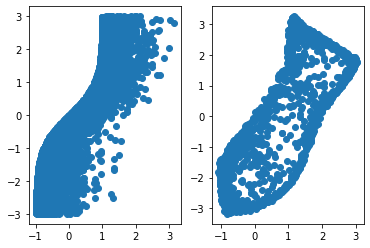

In [281]:
data_in_batch = data_in_batch.cpu().detach()
#data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data_transformed[0], data_transformed[1])
ax2.scatter(data_in_batch[0], data_in_batch[1])
#ax1.set_xlim([-2, 4])
#ax1.set_ylim([-3.5, 3.5])

#ax2.set_xlim([-2, 4])
#ax2.set_ylim([-3.5, 3.5])

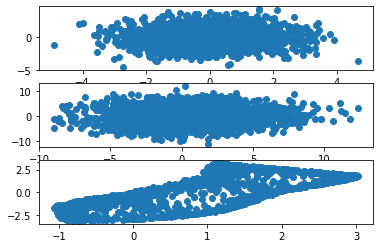

In [283]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 299][0], datas[timesteps - 299][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

<ipython-input-279-5c3dd5efb4ea>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


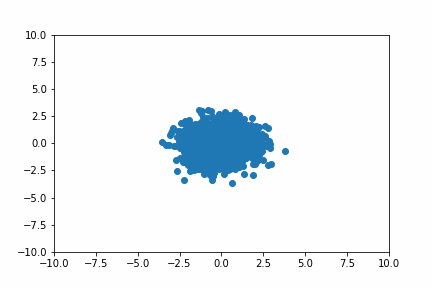

In [279]:
import imageio 
from IPython.display import Image

def print_gif(datas, name):
    filenames = []
    for i in range(0, timesteps-20, 10):
        # plot the line chart
        plt.scatter(datas[i][0], datas[i][1])
        plt.ylim(-10,10)
        plt.xlim(-10, 10)

        # create file name and append it to a list
        filename = f'para-{i}.png'
        filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()

    for j in range(timesteps-20, timesteps-1, 1):
    # plot the line chart
        plt.scatter(datas[j][0], datas[j][1])
        plt.ylim(-10,10)
        plt.xlim(-10, 10)

        # create file name and append it to a list
        filename = f'para-{i+j}.png'
        filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()

    images = list(map(lambda filename: imageio.imread(filename), filenames))

    imageio.mimsave(os.path.join(name), images, ms=300) # modify the frame duration as needed

    # Remove files
    for filename in set(filenames):
        os.remove(filename)
    with open(name,'rb') as f:
        display(Image(data=f.read(), format='png'))


print_gif(datas, 'para.gif')